In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import time

In [2]:
import os
os.chdir('..')
import rwpropa as rw

### "Compact" astrophysical sources

Charged particles (comsic rays (CRs)) are accelerated to high energies in astrophysical sources until the gyration radius exceeds the system size according to the Hillas criterion and the CRs can no longer be confined by the accelerator. Since strong magnetic fields with a significant amount of turbulence typically prevail in these sources, the description of particle propagation in the sources is nontrivial and complicate the analytical description of transport. 

Simulations are used for describing as accurately as possible the particle transport that has an impact on numerous observable mulstimessenger signatures. In the following, we focus on the transport properties in these sources, which are described by the diffusion coefficient (see the introductions in the previous tutorials).

There are numerous possible sources covering a large parameter space of physical properties relevant to particle transport. For the comparison between RW and CR, we use typical parameters used in the literature for AGN plasmoids:
- isotropic 3d Kolmogorov turbulence
- magnetic field strength: 1 Gaus
- correlation length turbulence: $\sim10^{11}$ m
- particle energies: 100 PeV

In [3]:
l_c = 1.05*10**11 # [m]
energy = 10**17 # [eV]

These parameters will result in gyroradii of the charged CRs:
\begin{align}
r_\mathrm{g} = \frac{E}{q\,c\,B} = \frac{100\,\mathrm{PeV}}{q\,c \cdot 1\mathrm{G}} \approx 3.34\cdot10^{12}\,\mathrm{m}.
\end{align}

In [4]:
r_g = 3.34*10**12 # [m]

Particles are in the quasi-ballistic transport regime ($r_\mathrm{g} \gg l_\mathrm{c}$), where they experience only minor deflections. The expected diffusion coefficient $\kappa$ is (see e.g. Subedi, P. et al. 2017, ApJ, 837, 140. doi:10.3847/1538-4357/aa603a):
\begin{align}
\kappa_\mathrm{theory} = \frac{r_\mathrm{g}^2 \cdot c}{2l_\mathrm{c}} = \frac{(3.34\cdot10^{12}\,\mathrm{m})^2 \cdot c}{2\cdot 1.05 \cdot 10^{11}\,m} \approx 1.59\cdot10^{23}\,\frac{\mathrm{m^2}}{\mathrm{s}}.
\end{align}

In [5]:
kappa_theory = 1.59*10**23 # [m^2/s]

This theoretical diffusion coefficient serves as an input for the RWPropa simulation and as a reference for the numerical simulations.

This diffusion coefficient results in expected mean-free paths of
\begin{align}
\lambda_\mathrm{theory} = \frac{3 \kappa_\mathrm{theory}}{c} \approx 1.6\cdot10^{15}\,\mathrm{m}.
\end{align}
Particles become diffusive at trajectory lengths of about $\lambda$, which is why we stop the simulations after trajectory lengths of $10^{17}$ to have some buffer and a clear plateau in the running diffusion coefficients.

In [6]:
lambda_theory = 1.6*10**15 # [m]
traj_max = 10**17 # [m]

### Simulations with CRPropa
CRPropa is a state of the art propagation code that can propagate CRs by solving both the equation of motion (ballistic) and the transport equation (diffusive) in arbitrary magnetic fields. 

#### Installation
Following the installation of CRPropa in a virtuelenv as described in https://crpropa.github.io/CRPropa3/pages/Installation.html

#### Simulation
Run the **simulation script** *comparison/crp_sim_agn.py* in your CRPropa environment:
This starts 15 simulations with varying step sizes of the integration routine. This convergence test is necessary to find the required resolution (step size) of the simulation routine that solves the equation of motion. The simulation results are evaluated by determining the diffusion coefficients, which provide a statistical description of the transport. 

#### Simulation results
The raw data (position, momentum,..) of the simulations are stored in */comparison/data/raw_data*. The analyzed data (diffusion coefficients, simulation time,..) are stored in */comparison/data* and will be used in the following. 

### Simulations with RWPropa
In the following we perform the same simulations as in CRPropa with RWPropa.

______________________________________________________________
simulate with a diffusion coefficient of  1.59e+23 m²/s
start simulation
Propagator initialized
Observer initialized
saved data file comparison/data/raw_data/rwpropa_1000.0.pkl
CPU times: user 200 ms, sys: 0 ns, total: 200 ms
Wall time: 199 ms
time needed:  0.2009702819999859 s
init statistics plotting class
______________________________________________________________
simulate with a diffusion coefficient of  1.59e+23 m²/s
start simulation
Propagator initialized
Observer initialized
saved data file comparison/data/raw_data/rwpropa_517.9474679231203.pkl
CPU times: user 394 ms, sys: 0 ns, total: 394 ms
Wall time: 393 ms
time needed:  0.3944909919999873 s
init statistics plotting class
______________________________________________________________
simulate with a diffusion coefficient of  1.59e+23 m²/s
start simulation
Propagator initialized
Observer initialized
saved data file comparison/data/raw_data/rwpropa_268.2695795279

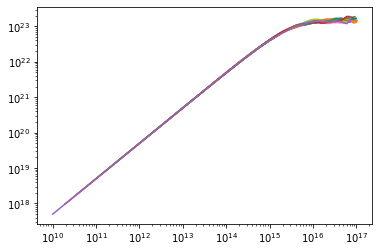

In [16]:
step_sizes = np.logspace(10, 14, 15)

sim = rw.IsotropicSimulation(nr_particles = 10**2, energy = energy, step_size = 10**14, nr_steps = 10, diffusion_coefficient_para = kappa_theory, nr_obs_steps = 1)
df_sim_data = pd.DataFrame(columns=('step_size', 'time', 'kappa', 'kappa_err'))

for i, step_size in enumerate(step_sizes[::-1]):
    print('______________________________________________________________')
    nr_steps = int(traj_max/step_size)
    sim = rw.IsotropicSimulation(nr_particles = 10**2, energy = energy, step_size = step_size, nr_steps = nr_steps, diffusion_coefficient_para = kappa_theory, nr_obs_steps = 100)
    file_name = 'comparison/data/raw_data/rwpropa_'+str(step_size/10**11)
    start_time = time.process_time()
    %time sim.simulate(file_name)
    time_needed = time.process_time() - start_time
    print('time needed: ', time_needed, 's')
    df = pd.read_pickle(file_name+'.pkl')
    sta = rw.Statistics(df)
    df_kappas = sta.get_diffusion_coefficients()
    df_sim_data.loc[i] = [step_size, time_needed, np.mean(df_kappas['kappa'][-10:]), np.std(df_kappas['kappa'][-10:])]
    plt.plot(df_kappas['l'], (df_kappas['kappa']))
    file_name = 'comparison/data/sim_result_rwp_'
    np.save(file_name+str(step_size/10**11)+'_l.npy', np.array(df_kappas['l']))
    np.save(file_name+str(step_size/10**11)+'_kappa.npy', np.array(df_kappas['kappa']))

plt.loglog()
file_name_results = 'comparison/data/rwp_sim_data.pkl'
df_sim_data.to_pickle(file_name_results)

### Comparison of simulation results
#### Convergence test for step sizes

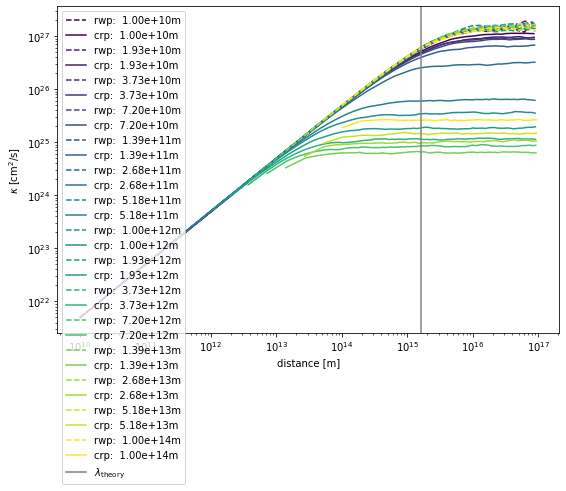

[1.1244229983615011e+23, 9.484316603297475e+22, 9.27279744653434e+22, 8.772100204622357e+22, 6.652318055236271e+22, 3.161338272106467e+22, 6.278609666178026e+21, 3.6099226379957484e+21, 1.9358803838601053e+21, 1.1454623981173299e+21, 8.771915939481013e+20, 6.336303842106984e+20, 1.056464599599921e+21, 1.4762451279486787e+21, 2.6403022914175243e+21]


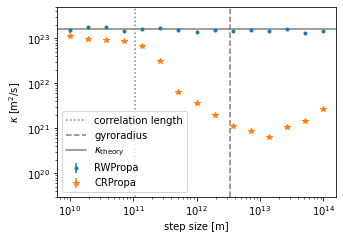

In [17]:
fig, ax1 = plt.subplots(figsize=(9,6))
kappas_crp = []
kappas_crp_err = []
kappas_rwp = []
kappas_rwp_err = []
steps_crp = [] 
steps_rwp = []

for i, step_size in enumerate(step_sizes):
    color = plt.cm.viridis(np.linspace(0, 1, len(step_sizes))[i])
    n_max = -1
    try:
        rwp_l = np.load('comparison/data/sim_result_rwp_'+str(step_size/10**11)+'_l.npy')
        rwp_kappa = np.load('comparison/data/sim_result_rwp_'+str(step_size/10**11)+'_kappa.npy')
        kappas_rwp.append(np.mean(rwp_kappa[-5:]))
        kappas_rwp_err.append(np.std(rwp_kappa[-5:]))
        steps_rwp.append(step_size)
        ax1.plot(rwp_l[:n_max], np.array(rwp_kappa[:n_max])*10**4, color=color, ls='--', label=str("rwp:  {:.2e}".format(step_size))+'m') 
    except:
        print('no data')
    
    try:
        crp_l = np.load('comparison/data/sim_result_crp_'+str(step_size/10**11)+'_l.npy')
        crp_kappa = np.load('comparison/data/sim_result_crp_'+str(step_size/10**11)+'_kappa.npy')
        kappas_crp.append(np.mean(crp_kappa[-5:]))
        kappas_crp_err.append(np.std(crp_kappa[-5:]))
        steps_crp.append(step_size)
        ax1.plot(crp_l[:n_max], np.array(crp_kappa[:n_max])*10**4, color=color, ls='-', label=str("crp:  {:.2e}".format(step_size))+'m')
    except:
        print('no data')
        
plt.axvline(x=lambda_theory, color='grey', linestyle='-', label='$\lambda_\mathrm{theory}$')        
ax1.set_xlabel('distance [m]')
ax1.loglog()
ax1.set_ylabel('$\kappa$ [cm$^2$/s]')
#plt.ylim([8e26, 10e26])
plt.legend()
plt.show()

fig, ax1 = plt.subplots(figsize=(5,3.5))
#plt.scatter(steps_rwp, kappas_rwp, c='k', label='rwp')
#plt.scatter(steps_crp, kappas_crp, c='r', label='crp')
plt.errorbar(steps_rwp, kappas_rwp, kappas_rwp_err, fmt='.', label = 'RWPropa')
plt.errorbar(steps_crp, kappas_crp, kappas_crp_err, fmt='*', label = 'CRPropa')

print(kappas_crp)

plt.axvline(x=l_c, label='correlation length', color='grey', ls=':')
plt.axvline(x=r_g, label='gyroradius', color='grey', ls='--')
plt.axhline(y=kappa_theory, color='grey', linestyle='-', label='$\kappa_\mathrm{theory}$')
plt.xlabel('step size [m]')
plt.ylabel('$\kappa$ [m$^2$/s]')
plt.ylim([3e19,5e23])
ax1.loglog()
plt.legend()
plt.show()

1.59e+23


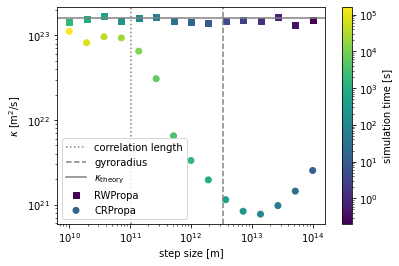

In [46]:
df_rwp_results = pd.read_pickle('comparison/data/rwp_sim_data.pkl')
df_crp_results = pd.read_pickle('comparison/data/crp_sim_data.pkl')
print(kappa_theory)
zs = np.concatenate([df_rwp_results['time'], df_crp_results['time']], axis=0)
min_, max_ = zs.min(), zs.max()
plt.scatter(df_rwp_results['step_size'], df_rwp_results['kappa'], c=df_rwp_results['time'], cmap='viridis', norm=matplotlib.colors.LogNorm(), marker='s', label='RWPropa')
plt.clim(min_, max_)
plt.scatter(df_crp_results['step_size'], df_crp_results['kappa'], c=df_crp_results['time'], cmap='viridis', norm=matplotlib.colors.LogNorm(), label='CRPropa')
plt.clim(min_, max_)
plt.colorbar(label='simulation time [s]')
plt.loglog()
plt.axvline(x=l_c, label='correlation length', color='grey', ls=':')
plt.axvline(x=r_g, label='gyroradius', color='grey', ls='--')
plt.axhline(y=kappa_theory, color='grey', linestyle='-', label='$\kappa_\mathrm{theory}$')


plt.xlabel('step size [m]')
plt.ylabel('$\kappa$ [m$^2$/s]')
plt.legend()
plt.show()

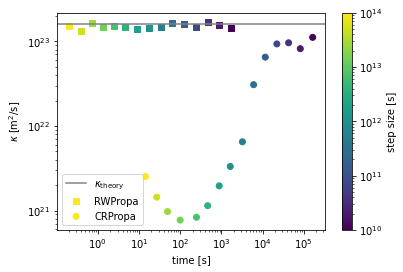

In [45]:
df_rwp_results = pd.read_pickle('comparison/data/rwp_sim_data.pkl')
df_crp_results = pd.read_pickle('comparison/data/crp_sim_data.pkl')

zs = np.concatenate([df_rwp_results['step_size'], df_crp_results['step_size']], axis=0)
min_, max_ = zs.min(), zs.max()
plt.scatter(df_rwp_results['time'], df_rwp_results['kappa'], c=df_rwp_results['step_size'], cmap='viridis', norm=matplotlib.colors.LogNorm(), marker='s', label='RWPropa')
plt.clim(min_, max_)
plt.scatter(df_crp_results['time'], df_crp_results['kappa'], c=df_crp_results['step_size'], cmap='viridis', norm=matplotlib.colors.LogNorm(), label='CRPropa')
plt.clim(min_, max_)
plt.colorbar(label='step size [s]')
plt.loglog()
plt.axhline(y=kappa_theory, color='grey', linestyle='-', label='$\kappa_\mathrm{theory}$')

plt.xlabel('time [s]')
plt.ylabel('$\kappa$ [m$^2$/s]')
plt.legend()
plt.show()

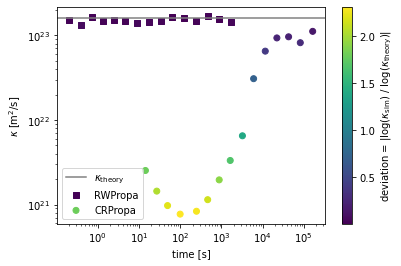

In [47]:
df_rwp_results = pd.read_pickle('comparison/data/rwp_sim_data.pkl')
df_crp_results = pd.read_pickle('comparison/data/crp_sim_data.pkl')

err_rwp = np.abs(np.log10(df_rwp_results['kappa'])-np.log10(kappa_theory))
err_crp = np.abs(np.log10(df_crp_results['kappa'])-np.log10(kappa_theory))
zs = np.concatenate([err_rwp, err_crp], axis=0)
min_, max_ = zs.min(), zs.max()
plt.scatter(df_rwp_results['time'], df_rwp_results['kappa'], c=err_rwp, cmap='viridis', marker='s', label='RWPropa')
plt.clim(min_, max_)
plt.scatter(df_crp_results['time'], df_crp_results['kappa'], c=err_crp, cmap='viridis', label='CRPropa')
plt.clim(min_, max_)
plt.colorbar(label='deviation = |log($\kappa_\mathrm{sim}$) / log($\kappa_\mathrm{theory}$)|')
plt.loglog()
plt.axhline(y=kappa_theory, color='grey', linestyle='-', label='$\kappa_\mathrm{theory}$')

plt.xlabel('time [s]')
plt.ylabel('$\kappa$ [m$^2$/s]')
plt.legend()
plt.show()

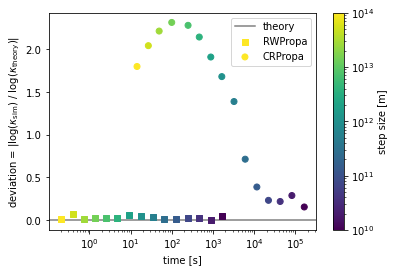

In [49]:
df_rwp_results = pd.read_pickle('comparison/data/rwp_sim_data.pkl')
df_crp_results = pd.read_pickle('comparison/data/crp_sim_data.pkl')

plt.axhline(y=0, color='grey', linestyle='-', zorder=-1, label='theory')

err_rwp = np.abs(np.log10(df_rwp_results['kappa'])-np.log10(kappa_theory))
err_crp = np.abs(np.log10(df_crp_results['kappa'])-np.log10(kappa_theory))
zs = np.concatenate([df_rwp_results['step_size'], df_crp_results['step_size']], axis=0)
min_, max_ = zs.min(), zs.max()
plt.scatter(df_rwp_results['time'], err_rwp, c=df_rwp_results['step_size'], norm=matplotlib.colors.LogNorm(), cmap='viridis', marker='s', label='RWPropa')
plt.clim(min_, max_)
plt.scatter(df_crp_results['time'], err_crp, c=df_crp_results['step_size'], norm=matplotlib.colors.LogNorm(), cmap='viridis', label='CRPropa')
plt.clim(min_, max_)
plt.colorbar(label='step size [m]')
plt.xscale('log')

plt.xlabel('time [s]')
plt.ylabel('deviation = |log($\kappa_\mathrm{sim}$) / log($\kappa_\mathrm{theory}$)|')
plt.legend()
plt.show()